<a href="https://colab.research.google.com/github/xli2522/expanding-universe/blob/main/Expanding_Universe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q lmfit 

     |████████████████████████████████| 292 kB 6.8 MB/s 
     |████████████████████████████████| 40 kB 3.9 MB/s 
     |████████████████████████████████| 98 kB 6.6 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit 
import pandas as pd
import re

In [ ]:
# extract data from the 2011 
data=pd.read_csv('SCPUnion2.1_AllSNe.txt', sep=' & ', engine='python', dtype='object')

In [ ]:
print(data.columns)
data = data[data['status'] != r'f\\']       # remove failed data
print(data)

Index(['Name', 'RedShift', 'B-Band Magnitude', 'Stretch', 'Color',
       'Distance Modulus', 'Sample', 'CutsFailed', 'status'],
      dtype='object')
       Name RedShift B-Band Magnitude      Stretch        Color  \
0    1993ah   0.0285      16.86(0.19)  -2.26(0.93)   0.23(0.09)   
1    1993ag   0.0500      17.79(0.05)  -1.09(0.24)   0.12(0.02)   
2     1993o   0.0529      17.60(0.05)  -1.03(0.14)  -0.01(0.02)   
3     1993b   0.0701      18.43(0.04)  -0.53(0.21)   0.09(0.02)   
4    1992bs   0.0627      18.25(0.05)  -0.27(0.23)   0.02(0.02)   
..      ...      ...              ...          ...          ...   
744   D-000   1.0170      25.20(0.12)  -0.61(0.65)   0.06(0.09)   
745   D-006   1.3150      25.68(0.13)  -1.26(0.56)  -0.06(0.06)   
746   P-009   0.8210      24.37(0.09)   0.25(0.50)   0.02(0.08)   
747   R-012   1.2150      25.79(0.16)  -2.06(1.53)  -0.16(0.20)   
748   Z-005   0.6230      23.48(0.15)  -0.76(0.89)   0.07(0.12)   

    Distance Modulus Sample CutsFailed     s

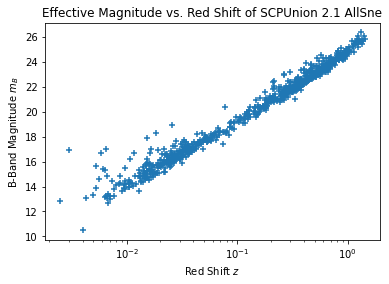

In [ ]:
magB = data['B-Band Magnitude'].values.tolist()
magB_error = data['B-Band Magnitude'].str.extract('.*\((.*)\).*').values.tolist()

# get magB error bar
magB_errorbar = []
for i in magB_error:
    try:
        magB_errorbar.append(float(i[0]))
    except:
        magB_errorbar.append(0)          
        
# get magB
magB_exact = []
for i in magB:
    exact = re.sub(r"\([^()]*\)", "", i)
    try:
        magB_exact.append(float(exact))
        #magB_errorbar.append(float(error_bar))
    except:
        magB_exact.append(0)          
        magB_error.append(0)       

# get red shift   
redShift = data['RedShift'].values.tolist()
redShift_exact = []
for i in redShift:
    exact = re.sub(r"\([^()]*\)", "", i)
    try:
        redShift_exact.append(float(exact))
    except:
        redShift_exact.append(0)

plt.scatter(redShift_exact, magB_exact, marker='+')
plt.xscale('log')
plt.xlabel(r'Red Shift $z$')
plt.ylabel(r'B-Band Magnitude $m_B$')
plt.title('Effective Magnitude vs. Red Shift of SCPUnion 2.1 AllSne')
plt.show()

### 1. Low Red Shift Data:

In [ ]:
# obtain low red shift data
redShift_float = np.float_(redShift_exact); magB_float = np.float_(magB_exact)        # convert all values to float
redShift_low_position = np.where(redShift_float <= 0.1)                               # get all low red shift positions
redShift_low = redShift_float[redShift_low_position]                                  # get low red shift values
magB_low = magB_float[redShift_low_position]

redShift_high_position = np.where(redShift_float > 0.1)                               # get all high red shift positions
redShift_high = redShift_float[redShift_high_position]                                # get high red shift values
magB_high = magB_float[redShift_high_position]

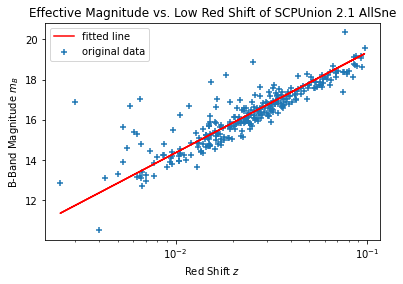

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 6
    # data points      = 286
    # variables        = 1
    chi-square         = 159.004419
    reduced chi-square = 0.55791024
    Akaike info crit   = -165.899108
    Bayesian info crit = -162.243116
[[Variables]]
    absMag: -18.0265112 +/- 0.04416713 (0.25%) (init = 0)
286


In [ ]:
# least-square fitting
from lmfit import minimize, Parameters, Parameter, report_fit

def residual(ps, magEff, z):
    '''The residual function for equation (2)'''
    M_c = ps['absMag'].value
    c = 3*10**8                         # speed of light 
    model = M_c + 5*np.log10(c*z)       # equation (2)

    return (model - magEff).ravel()

params = Parameters()
params.add('absMag', value = 0)         # set the chirp mass as the only variable

result_fit = minimize(residual, params, args=(magB_low, redShift_low), method='least_squares')
final_fit = magB_low + result_fit.residual.reshape(magB_low.shape)

plt.scatter(redShift_low, magB_low, marker='+', label='original data')          # original low red shift data
plt.plot(redShift_low, final_fit, c='r', label='fitted line')                   # fitted magB values combined with original low red shift data

plt.xscale('log')
plt.xlabel(r'Red Shift $z$')
plt.ylabel(r'B-Band Magnitude $m_B$')
plt.title('Effective Magnitude vs. Low Red Shift of SCPUnion 2.1 AllSne')
plt.legend()
plt.show()

report_fit(result_fit)
print(len(redShift_low))

### 1.2 Luminosity Distance and Energy Densities

In [ ]:
from scipy.integrate import odeint

In [ ]:
# full data fitting with absMag = - 18.02 (from equation 2 fitting) in equation (1)
def intfunc(dDdt, zp, omegaM, omegaD):
    '''Content of the integral in equation (1)'''
    dDdt = 1/(np.sqrt(omegaM*(1+zp)**3 + omegaD))
    
    return dDdt 

def residual(ps, magEff, z, M_c):
    '''The residual function for equation (1)'''
    omegaM = ps['omegaM'].value
    omegaD = ps['omegaD'].value

    c = 3*10**8                       # speed of light 
    model = np.zeros(len(z))          # length of red shift values ~714
    n = 0
    for i in z:                       # for loop to facilitate numerical integration
       
        # for each red shift value i, calculate the coressponding integral result from 0 to i
        zp=np.linspace(0, i, 100)                                         # red shift value in the integral should match the i in equation (1)
        integral = odeint(intfunc, 0, zp, args=(omegaM, omegaD))          # numerical integration
        int_result = integral[-1]-integral[0]                             # final value - initial value
        # the value of equation (1) at red shift value i, densities omegaM and omegaD
        model[n] = M_c + 5*np.log10(c*(1+i)*int_result)                   # the magnitude model - equation (1)
        n+=1

    return (model - magEff).ravel()

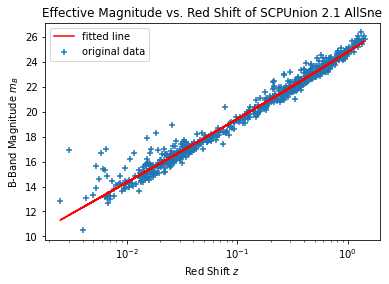

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 38
    # data points      = 714
    # variables        = 2
    chi-square         = 216.819251
    reduced chi-square = 0.30452142
    Akaike info crit   = -846.958693
    Bayesian info crit = -837.816928
[[Variables]]
    omegaM:  0.85717071 +/- 0.07310651 (8.53%) (init = 1e-05)
    omegaD:  0.18903749 +/- 0.09582563 (50.69%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(omegaM, omegaD) = -0.966


In [ ]:
params = Parameters()
params.add('omegaM', value=0.00001)        # set energy densities as variables
params.add('omegaD', value=0.00001)         

result_fit = minimize(residual, params, args=(magB_float, redShift_float, -18.02), method='least_squares')
final_fit = magB_float + result_fit.residual.reshape(magB_float.shape)

plt.scatter(redShift_float, magB_float, marker='+', label='original data')        # original red shift data
plt.plot(redShift_float, final_fit, c='r', label='fitted line')                   # fitted magB value

plt.xscale('log')
plt.xlabel(r'Red Shift $z$')
plt.ylabel(r'B-Band Magnitude $m_B$')
plt.title('Effective Magnitude vs. Red Shift of SCPUnion 2.1 AllSne')
plt.legend()
plt.show()

report_fit(result_fit)

### 1.3 All Data w/ Explicit Flat Universe

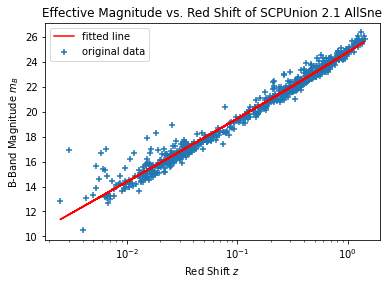

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 31
    # data points      = 714
    # variables        = 1
    chi-square         = 217.463207
    reduced chi-square = 0.30499748
    Akaike info crit   = -846.841250
    Bayesian info crit = -842.270367
[[Variables]]
    omegaM:  0.92815928 +/- 0.05917651 (6.38%) (init = 1e-05)
    omegaD:  0.07184072 +/- 0.05917651 (82.37%) == '1 - omegaM'


In [ ]:
params = Parameters()
params.add('omegaM', value=0.00001, min = 0, max = 1)        
params.add('omegaD', value=0.00001, expr='1 - omegaM')       # enforce the flat universe constrain omegaM + omegaD = 1

result_fit = minimize(residual, params, args=(magB_float, redShift_float, -18.02), method='least_squares')
final_fit = magB_float + result_fit.residual.reshape(magB_float.shape)

plt.scatter(redShift_float, magB_float, marker='+', label='original data')         # original red shift data
plt.plot(redShift_float, final_fit, c='r', label='fitted line')                  # fitted magB value

plt.xscale('log')
plt.xlabel(r'Red Shift $z$')
plt.ylabel(r'B-Band Magnitude $m_B$')
plt.title('Effective Magnitude vs. Red Shift of SCPUnion 2.1 AllSne')
plt.legend()
plt.show()

report_fit(result_fit)

### 1.4 All Data w/ Different Densities

In [ ]:
def luminosityB(z, M_c, omegaM, omegaD):
    '''Equation (1) model'''
    c = 3*10**8                       # speed of light 
    model = np.zeros(len(z))          # length of red shift values ~714
    n = 0
    for i in z:                       # for loop to facilitate numerical integration
       
        # for each red shift value i, calculate the coressponding integral result from 0 to i
        zp=np.linspace(0, i, 100)                                         # red shift value in the integral should match the i in equation (1)
        integral = odeint(intfunc, 0, zp, args=(omegaM, omegaD))          # numerical integration
        int_result = integral[-1]-integral[0]                             # final value - initial value
        # the value of equation (1) at red shift value i, densities omegaM and omegaD
        model[n] = M_c + 5*np.log10(c*(1+i)*int_result)                   # the magnitude model - equation (1)
        n+=1

    return model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


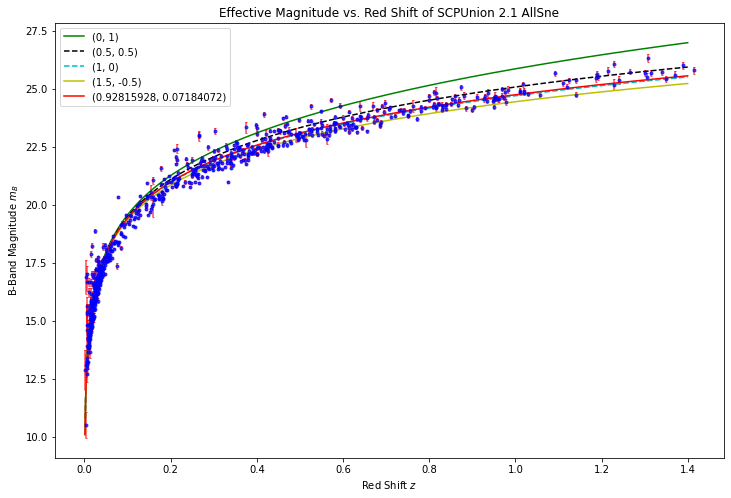

In [ ]:
# Here we go through the least-square fitting with fixed energy densities to generate fitting statistics report
z_continuous = np.linspace(0, 1.4, 1000)                  # the range of red shift z [0, 1.4]

# Case (0, 1) 
result_01 = luminosityB(z_continuous, -18.02, 0, 1)

# Case (0.5, 0.5) 
result_55 = luminosityB(z_continuous, -18.02, 0.5, 0.5)

# Case (1, 0) 
result_10 = luminosityB(z_continuous, -18.02, 1, 0)

# Case (1.5, -0.5) 
result_15 = luminosityB(z_continuous, -18.02, 1.5, -0.5)

# Case best fit (0.92815928, 0.07184072)
result_best = luminosityB(z_continuous, -18.02, 0.92815928,0.07184072)

fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.errorbar(redShift_float, magB_float, yerr=magB_errorbar, 
                      capsize=1, ms=3, fmt='bo', ecolor='r', 
                            barsabove=False,alpha=0.7)                   # original red shift data w/ error bar
#plt.scatter(redShift_float, magB_float, marker='o', c='b', s=4, )       # original red shift data

plt.plot(z_continuous, result_01, 'g', label='(0, 1)')               
plt.plot(z_continuous, result_55, 'k--', label='(0.5, 0.5)')
plt.plot(z_continuous, result_10, 'c--', label='(1, 0)')
plt.plot(z_continuous, result_15, 'y', label='(1.5, -0.5)')     
plt.plot(z_continuous, result_best, 'r', label='(0.92815928, 0.07184072)')

plt.xlabel(r'Red Shift $z$')
plt.ylabel(r'B-Band Magnitude $m_B$')
plt.title('Effective Magnitude vs. Red Shift of SCPUnion 2.1 AllSne')
plt.legend()
plt.show()
